In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt         
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
from tensorflow.keras import models, layers, regularizers, Input


In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)



In [3]:
def model_plots(history,name):
    plt.style.use('ggplot')
    
    fig1, ax1 = plt.subplots(figsize=(6,6))
    metrics = ['acc','val_acc']
    for metric in metrics:
        ax1 = plt.plot(history.history[metric], label=metric)
    ax1 = plt.title(f'{name}-Accuracy')

    ax1 = plt.legend()
    ax1 = plt.tight_layout()
    ax1 = plt.xlabel('Epochs')
    ax1 = plt.ylabel('Accuracy')
    fig1.savefig(f'Images/{name}-accuracy.jpg',bbox_inches='tight', dpi=150)
    
    fig2, ax2 = plt.subplots(figsize=(6,6))
    metrics = ['loss','val_loss']
    for metric in metrics:
        ax2 = plt.plot(history.history[metric], label=metric)
    ax2 = plt.title(f'{name}-Loss')

    ax2 = plt.legend()
    ax2 = plt.tight_layout()
    ax2 = plt.xlabel('Epochs')
    ax2 = plt.ylabel('Loss')
    fig2.savefig(f'Images/{name}-loss.jpg',bbox_inches='tight', dpi=150)

In [4]:
layers_list = []

def modeler(layers_list):
    
    model = models.Sequential()
    model.add(layers.InputLayer((75,75,3)))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu'))

    
    for layer in layers_list:
        model.add(layer)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(6,activation='softmax'))
    
    
 
    return model

In [5]:
def model_trainer(model,name,train_img,train_labels,test_img,test_labels,batch_size=16,epochs=5):
    
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../../../../Models/{name}_model.h5', save_best_only=True)
    earlystop = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', # What to watch
                                min_delta=0.1, # How much change to get
                                patience=5 # No change after 5 epochs
    )
    history = model.fit(train_img,train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_img,test_labels),
                    callbacks=[checkpoint,earlystop])
    
    return history

In [6]:
#set image dims
dim = (75,75)

In [7]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['../../../../archive/seg_train/seg_train', '../../../../archive/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, dim) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [8]:
(train_images_resized, train_labels), (test_images_resized, test_labels) = load_data()

  7%|▋         | 162/2191 [00:00<00:01, 1604.61it/s]

Loading ../../../../archive/seg_train/seg_train


 39%|███▉      | 170/437 [00:00<00:00, 1684.13it/s]

Loading ../../../../archive/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 1500.19it/s]


In [9]:
train_images_resized_scaled =train_images_resized.reshape((-1,75,75,3)).astype('float32') / 255.0
test_images_resized_scaled = test_images_resized.reshape((-1,75,75,3)).astype('float32') / 255.0

In [10]:
model = models.Sequential()



In [11]:
layers_list = [layers.Conv2D(128,(3,3),activation='relu'),
               layers.MaxPooling2D(3,3),
               layers.Dropout(0.35),
               layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=regularizers.l2(l2=0.01)),
               layers.Dropout(0.35)]

model = modeler(layers_list)

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 128)       147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 61952)             0         
_________________________________________________________________
dense (Dense)                (None, 128)              

In [13]:
history = model_trainer(model,'testing_inputlayer',train_images_resized_scaled,train_labels,test_images_resized_scaled,test_labels,epochs=5)

Epoch 1/5
878/878 [==============================] - 126s 143ms/step - loss: 1.1529 - acc: 0.5765 - val_loss: 0.8783 - val_acc: 0.6730
Epoch 2/5
878/878 [==============================] - 125s 142ms/step - loss: 0.8787 - acc: 0.6779 - val_loss: 0.8630 - val_acc: 0.6923
Epoch 3/5
878/878 [==============================] - 125s 143ms/step - loss: 0.7906 - acc: 0.7189 - val_loss: 0.7722 - val_acc: 0.7290
Epoch 4/5
878/878 [==============================] - 124s 142ms/step - loss: 0.7405 - acc: 0.7384 - val_loss: 0.7435 - val_acc: 0.7440
Epoch 5/5
878/878 [==============================] - 124s 141ms/step - loss: 0.6737 - acc: 0.7602 - val_loss: 0.7853 - val_acc: 0.7263


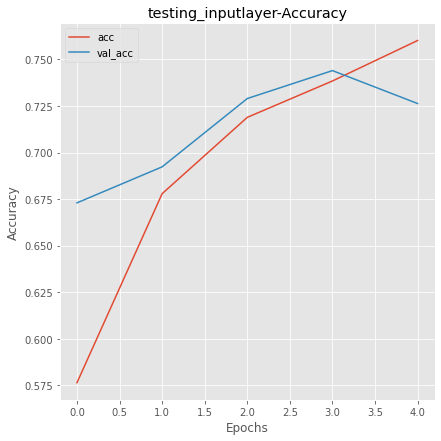

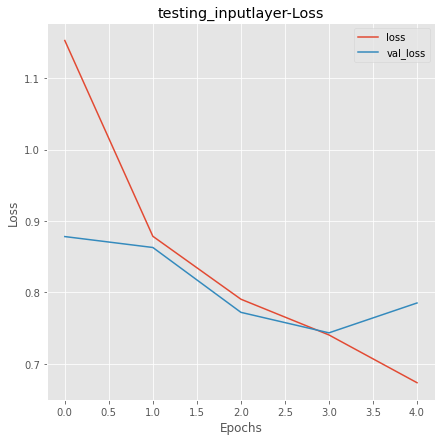

In [14]:
model_plots(history,'testing_inputlayer')

In [15]:
import lime

In [16]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [17]:
import random

In [18]:
explainer = lime_image.LimeImageExplainer(random_state=1)

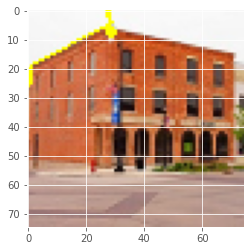

In [22]:
explanation = explainer.explain_instance(train_images_resized_scaled[10].astype('double'), model.predict)
plt.imshow(train_images_resized_scaled[10])
temp, mask = explanation.get_image_and_mask(model.predict(train_images_resized_scaled[10].reshape((1,75,75,3))).argmax(axis=1)[0], positive_only=True, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

In [24]:
model.predict(train_images_resized_scaled[10].reshape((1,75,75,3)))

array([[1.2481940e-03, 5.1266715e-02, 4.6415106e-04, 9.3978316e-01,
        7.2236964e-03, 1.4108292e-05]], dtype=float32)

In [ ]:
history.